# Exploration 7. 인물사진을 만들어 보자 😎

### 📸 인물사진 모드(portrait mode)
- DSLR에서는 사진을 촬영할 때 피사계 심도(depth of field, DOF)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만듭니다.
- 피사계 심도는 사진술에서 한 사진의 초점이 충분히 맞은 것으로 인식되는 범위의 한계
- 배경을 흐리게 하는 기술: 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus)
- 인물사진 모드: 보케(bokeh) = '인물사진(portrait)'
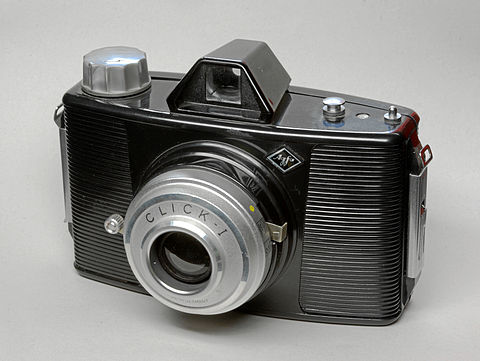

## 🤩 Step 1. 인물모드 직접 해보기

In [3]:
# 필요한 라이브러리 불러오기
import os
import urllib  # 웹에서 데이터 다운로드 시 사용
import cv2  # OpenCV 라이브러리: 이미지 처리 위해 사용
import numpy as np
from pixellib.semantic import semantic_segmentation  # 시맨틱 세그멘테이션 편하게 사용가능한 라이브러리
from matplotlib import pyplot as plt

(720, 1280, 3)


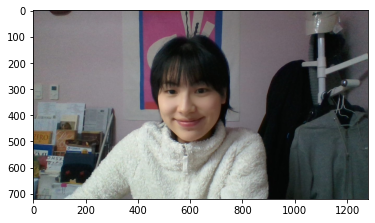

In [4]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 🪅🪅🪅 Shallow Focus 만들기
### (1) Semantic Segmentation하기
> 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법

#### - PixelLib에서 제공해 주는 모델 다운로드

In [8]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe77c44f8b0>)

#### - 세그멘테이션 모델 생성하기

In [9]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#### - 모델에 이미지를 입력하기

In [10]:
segvalues, output = model.segmentAsPascalvoc(img_path)

#### - PASCAL VOC 데이터로 학습된 모델 이용
> 학습시킨 데이터에 따라 결괏값이 달라지므로, 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요 !!

In [11]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

🥦 background를 제외하면 20개의 클래스
#### - 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내기

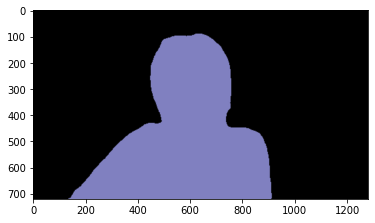

In [12]:
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

In [13]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [14]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


🥦 output: 세그멘테이션이 된 결과가 각각 다른 색상으로 담긴다.   
🥦 segvalues: class_ids와 masks가 있다.   
🥦 class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다 !! 

#### - output에 어떤 색상으로 나타나 있는지 알아내기

In [15]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

🥦 PixelLib에 따르면 위와 같은 색을 사용함. 
#### - 사람을 나타내는 15번째 색상 찾아내기

In [16]:
colormap[15]

array([192, 128, 128])

## 💊💊💊 **주의** 💊💊💊
- output 이미지는 **`BGR 순서`**로 채널 배치가 되어 있다.
- colormap은 **`RGB 순서`**

#### - 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야함

In [17]:
seg_color = (128,128,192)

#### - seg_color로만 이루어진 마스크 만들기

In [18]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

(720, 1280)


🥦 3채널 가졌던 원본과는 다르게 채널 정보가 사라진다.   
🥦 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 된다.

#### - 원래 이미지와 겹치게 하여 세그멘테이션이 얼마나 잘 되었는지 알아보기

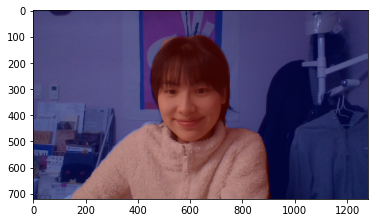

In [19]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

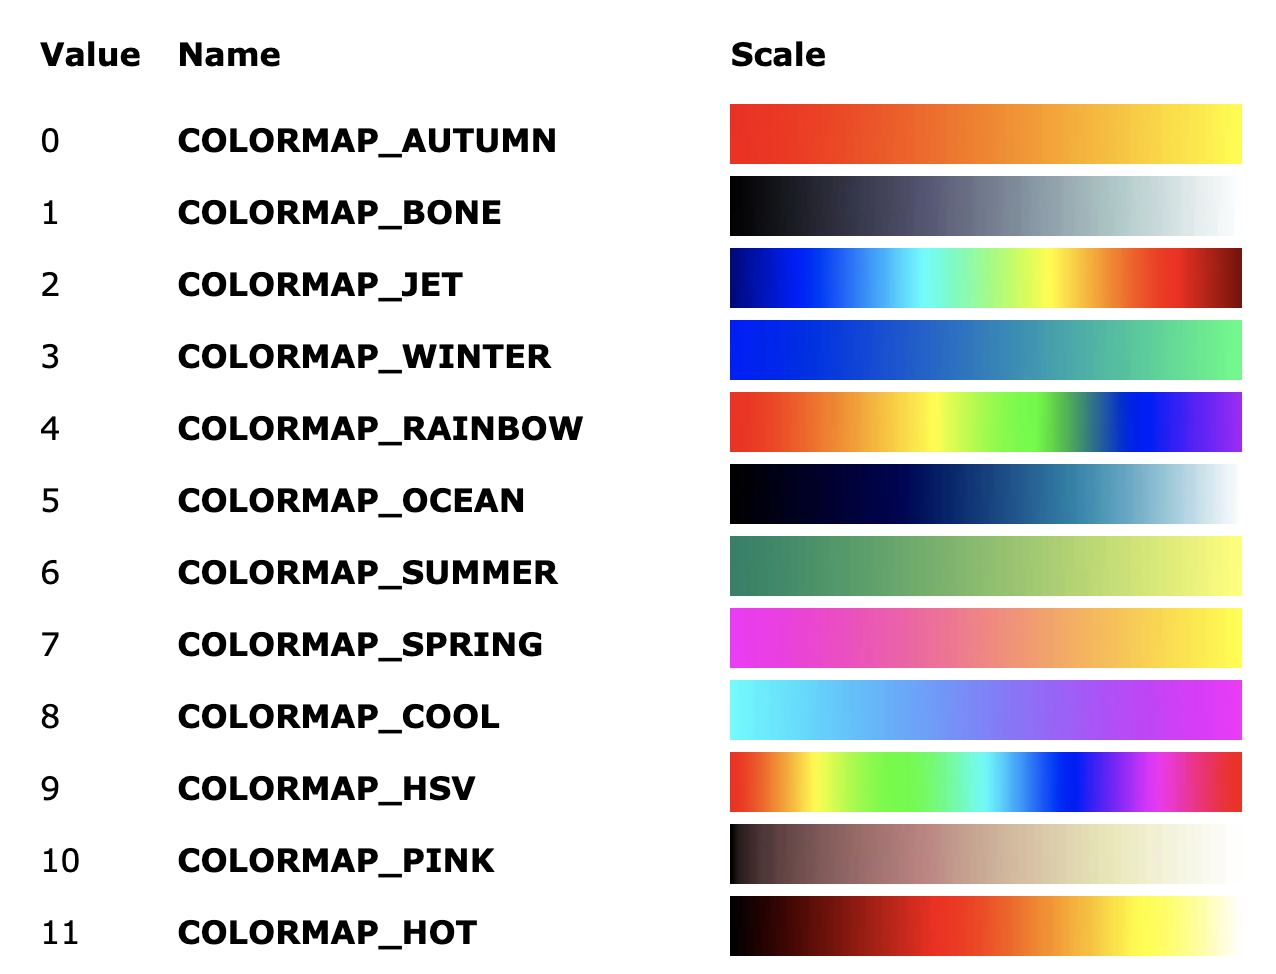

### (2) blur() 함수를 이용하여 배경 흐리게 하기

In [26]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))  # 드라마틱한 효과를 위해 (50, 50) 적용
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### - 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

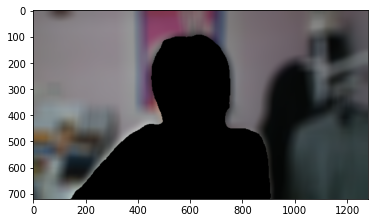

In [24]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # 배경 0, 사람 255
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not 연산 후 배경 255, 사람 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람 그대로 0 - 배경에 blur
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 🥦 bitwise_not 함수 
- 원래 마스크에서는 배경이 0, 사람이 255. 
- bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 된다. 

#### 🥦 bitwise_and 연산
- 배경만 있는 영상을 얻을 수 있다
- 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. 
- 결국 사람이 사라진다. 🙊🙊🙊

### (3) 흐린 배경과 원본 영상 합성하기
#### - 배경 영상과 사람 영상을 합치기

🥦 **`numpy.where(condition, x, y)`**  
> - 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용한다.   
> - `np.where(조건, 참일때, 거짓일때)`의 형식의 코드 사용.

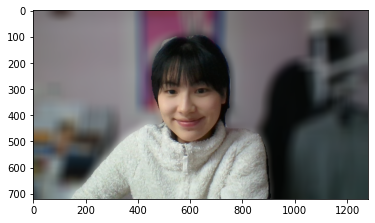

In [28]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  # 사람(255)이면 origin, 아니면 blur처리
# img_concat = np.where(img_bg_mask==255, img_bg_blur, img_orig)  # # 배경이면 origin, 아니면 blur처리
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 💊💊💊 흠... blurring kernel size에 (50, 50)을 적용해보니, 원본 이미지와 비교했을 때 확실히 배경이 흐려진 것을 볼 수 있다. 하지만 흐려지지 않아야 하는 왼쪽 팔 밑쪽 부근을 제외시키는 등... 조금 더 보완이 필요할 것으로 보인다. 

# 🪅🪅🪅 여러 이미지로 인물모드 사진 만들기 

>1. 배경에 포커싱, 얼굴에 블러 처리, 커피를 객체로 인식하는지 궁금
>2. 펭귄들 여러 마리 인식하는지 궁금, 배경 합성
>3. 배경 합성

### (1) 사용할 이미지 싹 다 불러오기

(3088, 2316, 3)


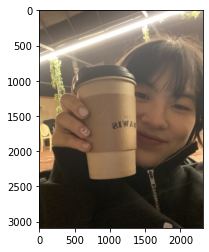

(600, 900, 3)


(2000, 2667, 3)


(1440, 1080, 3)


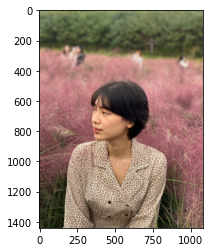

(867, 1300, 3)


In [42]:
img_path_blur = os.getenv('HOME')+'/aiffel/human_segmentation/images/blur.jpg'  
img_orig_blur = cv2.imread(img_path_blur)

img_path_penguin = os.getenv('HOME')+'/aiffel/human_segmentation/images/penguins.png'  
img_orig_penguin = cv2.imread(img_path_penguin)

img_path_beach = os.getenv('HOME')+'/aiffel/human_segmentation/images/beach.jpg'  
img_orig_beach = cv2.imread(img_path_beach)

img_path_me = os.getenv('HOME')+'/aiffel/human_segmentation/images/person.jpg'  
img_orig_me = cv2.imread(img_path_me)

img_path_flower = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  
img_orig_flower = cv2.imread(img_path_flower)

print(img_orig_blur.shape)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig_penguin.shape)
plt.imshow(cv2.cvtColor(img_orig_penguin, cv2.COLOR_BGR2RGB))
plt.show()

# penguins 배경으로 들어갈 이미지
print(img_orig_beach.shape)
plt.imshow(cv2.cvtColor(img_orig_beach, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig_me.shape)
plt.imshow(cv2.cvtColor(img_orig_me, cv2.COLOR_BGR2RGB))
plt.show()

# me 이미지 배경으로 들어갈 이미지
print(img_orig_flower.shape)
plt.imshow(cv2.cvtColor(img_orig_flower, cv2.COLOR_BGR2RGB))
plt.show()

#### - 이미지 합성을 위해 두 사진의 크기 동일하게 resize 하기
🥦 펭귄 이미지의 배경엔 바다 합성하기  
🥦 핑크뮬리 me 이미지의 배경엔 꽃밭 합성하기 

In [43]:
print(img_orig_penguin.shape)
print(img_orig_beach.shape)

print('---------------')

print(img_orig_me.shape)
print(img_orig_flower.shape)

(600, 900, 3)
(2000, 2667, 3)
---------------
(1440, 1080, 3)
(867, 1300, 3)


(600, 900, 3)


(1440, 1080, 3)


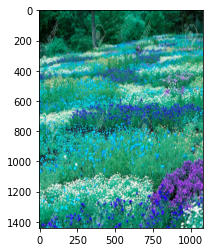

In [44]:
# 이미지 resize
img_beach_resize = cv2.resize(img_orig_beach, (900, 600))
img_flower_resize = cv2.resize(img_orig_flower, (1080, 1440))

print(img_beach_resize.shape)
plt.imshow(img_beach_resize)
plt.show()
print(img_flower_resize.shape)
plt.imshow(img_flower_resize)
plt.show()

### (2) 나머지 이미지들 Instance Segmentation 하기
#### - Segmentation 모델에 이미지 입력하기

In [45]:
segvalues_blur, output_blur = model.segmentAsPascalvoc(img_path_blur)
segvalues_penguin, output_penguin = model.segmentAsPascalvoc(img_path_penguin)
segvalues_me, output_me = model.segmentAsPascalvoc(img_path_me)

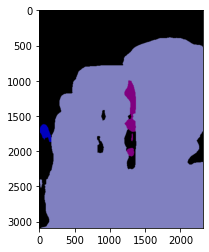

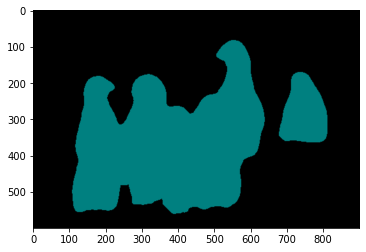

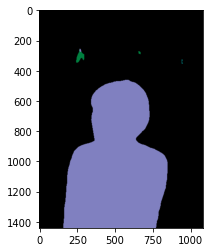

In [46]:
# output에서는 세그멘테이션 결과가 각각 다른 색으로 저장된다.
plt.imshow(output_blur)
plt.show()

plt.imshow(output_penguin)
plt.show()

plt.imshow(output_me)
plt.show()

#### - Pascal Voc 데이터의 라벨 종류 확인해보기

In [47]:
print(LABEL_NAMES)

['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']


In [48]:
segvalues_blur

{'class_ids': array([ 0,  5,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

#### 💊💊💊 bottle(커피)를 엄청 잘 인식하는 것 같아 보이지는 않음.. 딱 봐도 bottle인 사진을 사용했어야 함!! 

In [49]:
segvalues_penguin

{'class_ids': array([0, 3]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [50]:
segvalues_me

{'class_ids': array([ 0,  3, 10, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [57]:
for class_id in segvalues_blur['class_ids']:
    print(LABEL_NAMES[class_id]) # LABEL_NAMES에서 0, 5(bottle), 9(chair), 15(person) 인식

print('---------------')
    
for class_id in segvalues_penguin['class_ids']:
    print(LABEL_NAMES[class_id]) # LABEL_NAMES에서 0과 3(bird) 인식 

print('---------------')

for class_id in segvalues_me['class_ids']:
    print(LABEL_NAMES[class_id]) # LABEL_NAMES에서 0과 15(person) 말고는 틀림 

background
bottle
chair
person
---------------
background
bird
---------------
background
bird
cow
person


#### 💊💊💊 도대체 마지막 사진에 왜 cow와 bird가 나오는지 모르겠음... potted plant가 나올 것이라 예상함.
- 첫번째의 경우 chair는 다루지 않을 것임
- 세번째의 경우 person(15) 외에는 다루지 않을 것임

In [58]:
print(colormap[5]) # 병(커피) 
print(colormap[3]) # 새(펭귄)
print(colormap[15]) # 사람

[128   0 128]
[128 128   0]
[192 128 128]


#### - BGR을 RGB로 바꿔주기

In [59]:
seg_color_coffee = (128, 0, 128)
seg_color_penguin = (0, 128, 128)
seg_color_person = (128, 128, 192)

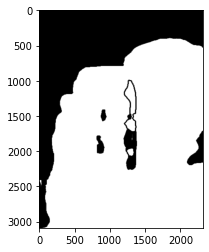

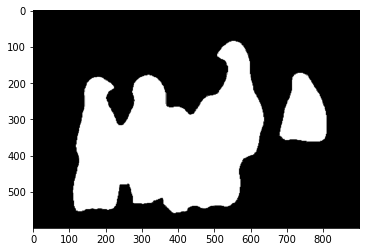

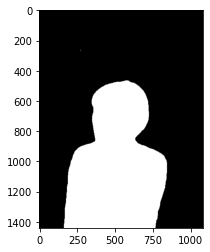

In [60]:
# all(): output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르면 0(False)
# numpy.logical_or()을 이용해 다중 조건 구현
seg_map_blur = np.all(np.logical_or(output_blur==seg_color_coffee, output_blur==seg_color_person), axis=-1)
# print(seg_map_blur.shape)
plt.imshow(seg_map_blur, cmap='gray')
plt.show()

seg_map_penguin = np.all(output_penguin==seg_color_penguin, axis=-1)
# print(seg_map_penguin.shape)
plt.imshow(seg_map_penguin, cmap='gray')
plt.show()

seg_map_me = np.all(output_me==seg_color_person, axis=-1)
# print(seg_map_me.shape)
plt.imshow(seg_map_me, cmap='gray')
plt.show()

#### - 원래 이미지와 겹치게 하여 세그멘테이션 잘 되었는지 확인하기

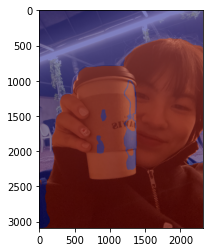

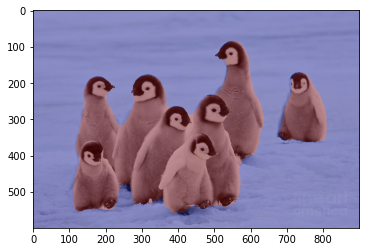

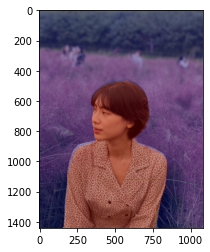

In [61]:
img_show_blur = img_orig_blur.copy()
img_show_penguin = img_orig_penguin.copy()
img_show_me = img_orig_me.copy()

# True와 False인 값을 각각 255, 0으로 바꿔주기
img_mask_blur = seg_map_blur.astype(np.uint8) * 255
img_mask_penguin = seg_map_penguin.astype(np.uint8) * 255
img_mask_me = seg_map_me.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경하기
color_mask_blur = cv2.applyColorMap(img_mask_blur, cv2.COLORMAP_JET)
color_mask_penguin = cv2.applyColorMap(img_mask_penguin, cv2.COLORMAP_JET)
color_mask_me = cv2.applyColorMap(img_mask_me, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지 섞는 비율
img_show_blur = cv2.addWeighted(img_show_blur, 0.5, color_mask_blur, 0.5, 0.0)
plt.imshow(cv2.cvtColor(img_show_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_show_penguin = cv2.addWeighted(img_show_penguin, 0.6, color_mask_penguin, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_penguin, cv2.COLOR_BGR2RGB))
plt.show()

img_show_me = cv2.addWeighted(img_show_me, 0.6, color_mask_me, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_me, cv2.COLOR_BGR2RGB))
plt.show()

### (2) blur() 처리하기
- 첫번째 사진 이외에 나머지 사진은 배경합성을 할 것으므로 pass.

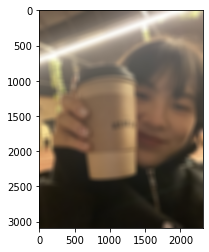

In [70]:
# (, )은 blurring kernel size를 의미
# 다양하게 바꿔보기
img_orig_blur_blur = cv2.blur(img_orig_blur, (80, 80))
plt.imshow(cv2.cvtColor(img_orig_blur_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### - 흐려진 이미지에 세그멘테이션 마스크를 이용해보기
**🥦` bitwise_not` 사용하지 않음**
> 배경을 그대로 0, 사람을 255로 두고 `bitwise_and`를 이용해 배경을 0으로 만들어 사라지게(검은색) 해야지만 우리가 원하는대로 배경에 포커싱이 되고 사람만 흐려짐. 

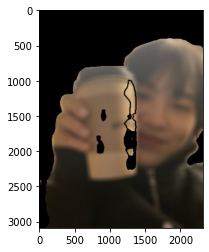

In [71]:
img_mask_color_blur = cv2.cvtColor(img_mask_blur, cv2.COLOR_GRAY2BGR) # 배경 0, 고양이 255
img_bg_blur_blur = cv2.bitwise_and(img_orig_blur_blur, img_mask_color_blur) # 배경 0 - 사라지게 함
plt.imshow(cv2.cvtColor(img_bg_blur_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [72]:
# penguin, me 사진은 블러처리가 필요하지 않기 때문에 mask만 설정해주었다.
img_mask_color_penguin = cv2.cvtColor(img_mask_penguin, cv2.COLOR_GRAY2BGR)

img_mask_color_me = cv2.cvtColor(img_mask_me, cv2.COLOR_GRAY2BGR)

#### - 배경과 사람 합치기

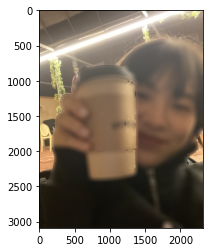

In [75]:
# 255는 객체, 0은 배경
img_concat_blur = np.where(img_mask_color_blur==255, img_bg_blur_blur, img_orig_blur) # 사람(255)면 blur, 아니면 origin
# np.where(img_mask_color_blur==0, img_orig_blur, img_bg_blur_blur) --> 이것도 가능!! 
plt.imshow(cv2.cvtColor(img_concat_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat_penguin = np.where(img_mask_color_penguin==255, img_orig_penguin, img_beach_resize) # 사람이면 penguin사진, 아니면 beach이미지
plt.imshow(cv2.cvtColor(img_concat_penguin, cv2.COLOR_BGR2RGB))
plt.show()

img_concat_me = np.where(img_mask_color_me==255, img_orig_me, img_flower_resize) # 아이유면 me사진, 아니면 flower사진
plt.imshow(cv2.cvtColor(img_concat_me, cv2.COLOR_BGR2RGB))
plt.show()

## 🤔 Step 2. 사진에서 문제점 찾기

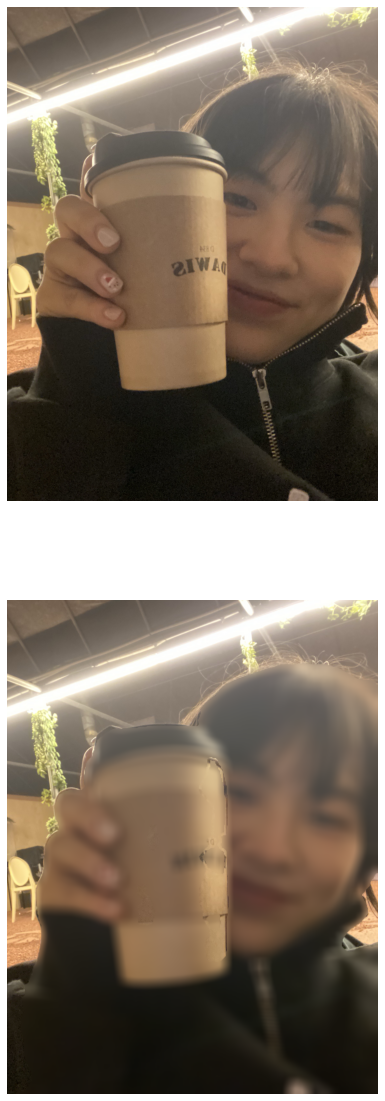

In [77]:
fig = plt.figure(figsize=(30, 20))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img_concat_blur, cv2.COLOR_BGR2RGB))
ax2.axis('off')

plt.show()

#### 💊💊💊 나름 굉장히 정교했지만, detail 측면에서 조금 문제가 있었다. 삐져나온 머리카락, 손가락 등.
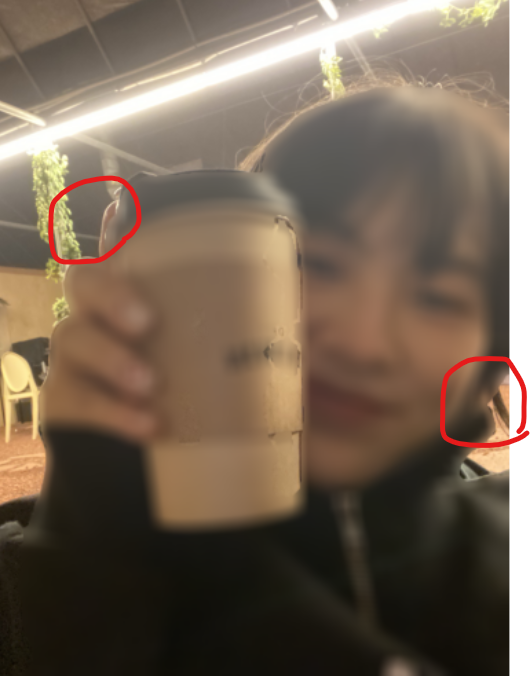

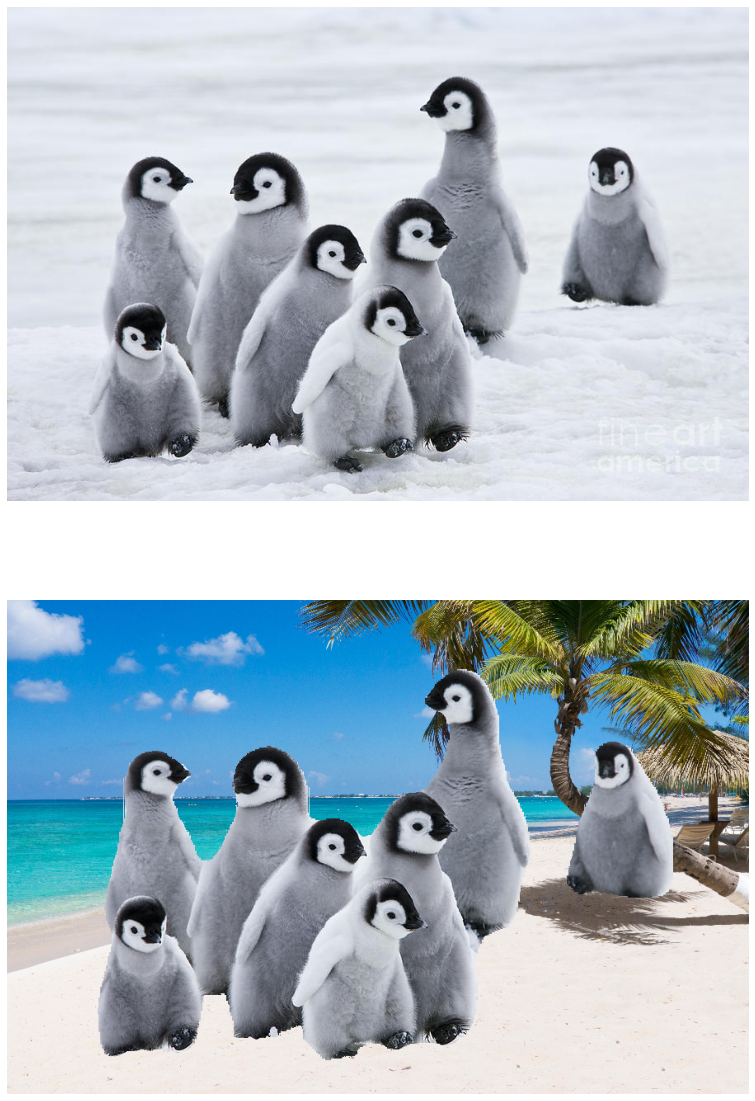

In [78]:
fig = plt.figure(figsize=(30, 20))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.imshow(cv2.cvtColor(img_orig_penguin, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img_concat_penguin, cv2.COLOR_BGR2RGB))
ax2.axis('off')

plt.show()

#### 💊💊💊 위 이미지와 비슷하게 큰 문제는 없어 보이나, 경계가 매끄럽지 않게 segmentation 된 부분들과 펭귄들의 부리가 잘려버리는 현상이 나타남... ouch ! 


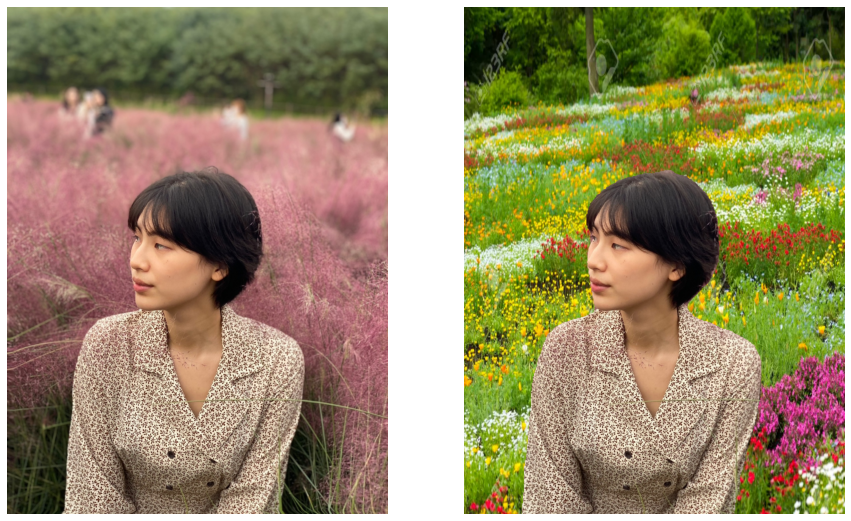

In [76]:
fig = plt.figure(figsize=(15, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(cv2.cvtColor(img_orig_me, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img_concat_me, cv2.COLOR_BGR2RGB))
ax2.axis('off')

plt.show()

### 🍎🍎🍎 이건 비교적 문제가 없어보인다 ^_^

## 🧐 Step 3. 해결 방법을 제안해 보기

#### 🍎 세그멘테이션의 한계 🍎
>Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

#### 🍎 피사계 심도 이해하기 🍎
>사진에서 초점이 맞은 것으로 인식되는 범위. 렌즈에서 초점이 맞는 거리(Focus Distance)는 딱 한 부분(Focus Point)인데, 이 부분을 중심으로 서서히 흐려지는 현상이 나타난다. 이 초점이 맞는 범위를 피사계 심도라고 한다.

- 심도가 얕으면 흔히 말하는 아웃포커싱이 된 것이고 (더 블러 처리)
- 심도가 깊으면 초점이 전체에 맞아 있을 것이다! (덜 블러 처리)

#### 🍎3D Camera 활용하기🍎  
>이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.


### (1) 가우시안 필터 (Gaussian Filter) 사용하기
: 가우시안 분포(Gaussian distribution) 함수를 근사해 생성한 필터 마스크를 사용하는 필터링 기법

> - 영상의 가우시안 필터에서는 평균이 0인 가우시안 분포 함수를 사용한다.
> - opencv에서 가우시안 필터링을 수행하기 위해 GaussianBlur() 함수를 제공함
> - blur()와의 차이점은 같이 흐림 효과를 주지만 전체적으로 밀도가 동일한 백색 노이즈를 제거하는 데 효과적

In [80]:
img_path_penguin = os.getenv('HOME')+'/aiffel/human_segmentation/images/penguins.png'  
img_orig_penguin = cv2.imread(img_path_penguin)

segvalues_penguin, output_penguin = model.segmentAsPascalvoc(img_path_penguin)

seg_color_penguin = (128, 0, 192)
seg_map_penguin = np.all(output_penguin==seg_color_penguin, axis=-1)

# True와 False인 값을 각각 255, 0으로 바꿔주기
img_mask_penguin = seg_map_penguin.astype(np.uint8) * 255
print(img_mask_penguin.shape)

(600, 900)


#### - GaussianBlur 사용해보기

In [81]:
# img_mask_penguin의 채널을 원본 사진과 맞게 3 channel로 바꿔준다.
img_mask_penguin_3C = np.repeat(np.expand_dims(img_mask_penguin, axis=2), 3, axis=2).astype(np.uint8)
print(img_mask_penguin_3C.shape)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_penguin_Gblur = cv2.GaussianBlur(img_orig_penguin, (65, 65), 0)

# 마스크 이미지를 가우시안 Blur 처리한다.
img_penguin_Gmask = (cv2.GaussianBlur(img_mask_penguin_3C, (31, 31), 65, 65) / 255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_penguin_blur = img_penguin_Gmask*img_orig_penguin.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_penguin_mask = (1-img_penguin_Gmask) * orig_penguin_Gblur.astype(np.float32)
img_penguin_output = (image_penguin_blur + img_bg_penguin_mask).astype(np.uint8)

(600, 900, 3)


#### - GaussianBlur 처리한 부분 확인하기

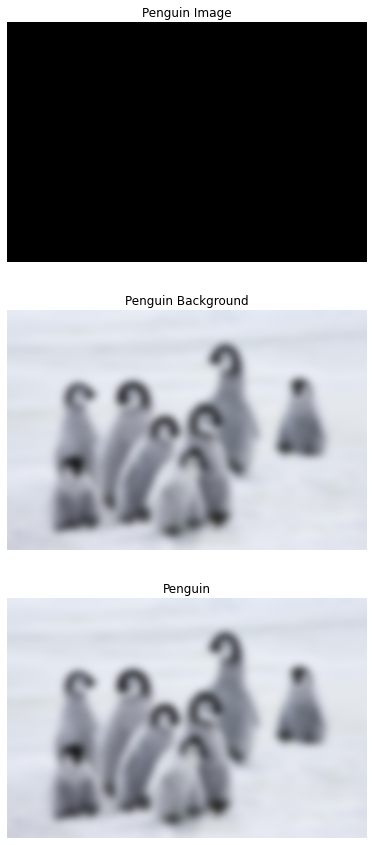

In [84]:
fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image_penguin_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('Penguin Image')
plt.axis('off')
ax = plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(img_bg_penguin_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('Penguin Background')
plt.axis('off')
ax = plt.subplot(3, 1, 3)
plt.imshow(cv2.cvtColor(img_penguin_output,cv2.COLOR_BGR2RGB))
plt.title('Penguin')
plt.axis('off')
plt.show()

#### - 그냥 blur 함수를 처리한 이미지와 GaussianBlur 함수를 처리한 이미지 비교하기

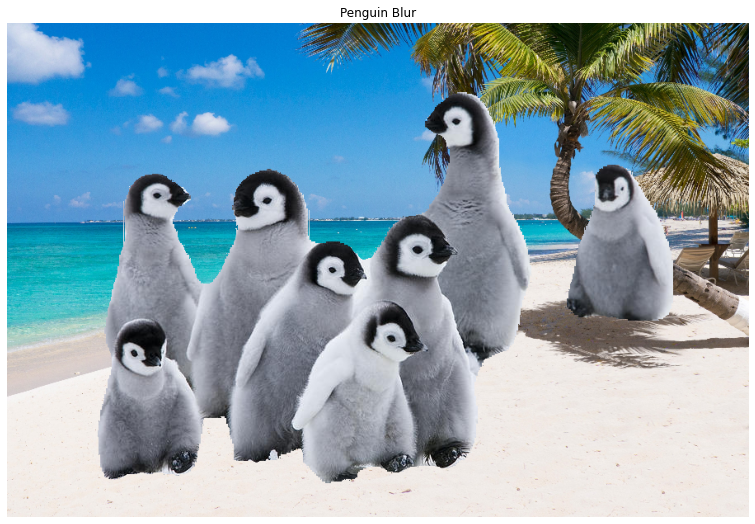

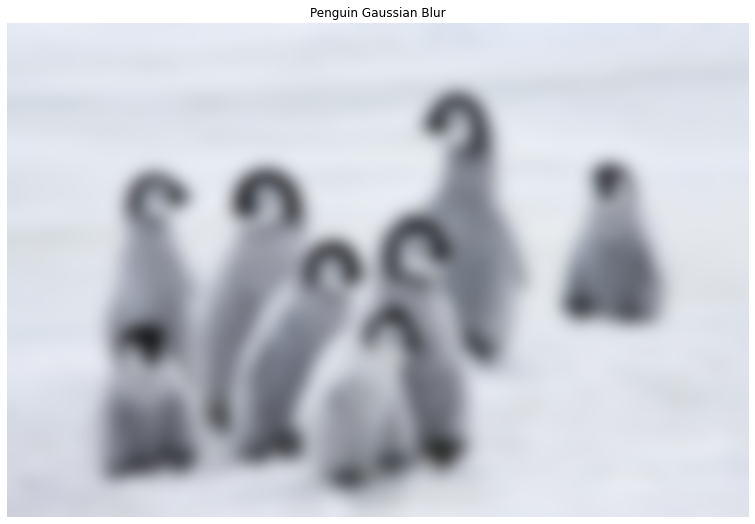

In [83]:
fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_concat_penguin, cv2.COLOR_BGR2RGB))
plt.title('Penguin Blur')
plt.axis('off')

fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_penguin_output,cv2.COLOR_BGR2RGB))
plt.title('Penguin Gaussian Blur')
plt.axis('off')
plt.show()

#### - 3d sensing
 3d depth 인식 기술은 Computational Camera의 한 종류로써 기존의 2D에서는 할 수 없었던 이미지 각 픽셀의 깊이 값을 계산할 수 있는 기술
 
 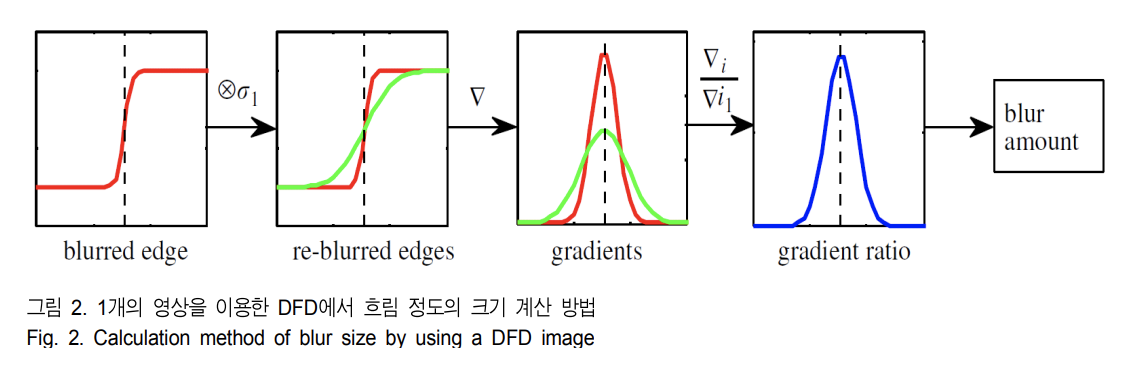
 

## 🪅🪅🪅 회고 🪅🪅🪅

1. 항상 그렇듯 프로젝트 시작 전에는 도대체 어떻게 해야할지 감이 안잡히기에 다른 사람들이 한 것을 많이 참고하게 되는데, 다 하고나면 뭐가 뭐인지 보인다. It's like connecting the dots (feat. Steve Jobs). 


2. 이번 노드는 실제로 카메라에서 "인물 사진"이라는 기능을 많이 사용하는 입장으로서 실생활과 밀접한 segmentation 모델을 배울 수 있어 더욱 흥미롭게 느껴졌다. 사실 NLP쪽으로 관심 분야가 기울었었는데 조금 더 균형있게 CV 분야도 공부하며 배워나가고 싶다. 


3. 사실 문제점을 찾으라고 했을 때 처음엔 저 정도면 훌륭하게 해낸거 아닌가 하는 생각이 들었었는데, step 2와 step 3을 통해 성능이나 정확도 측면에서 개선할 수 있는 방안이 너무나 많은데 나의 생각이 짧았음을 깨달았다. 


4. 이번엔 해결방안으로 Gaussian Blur밖에 사용하지 못했으나, 이후에 시간을 들여 3D Camera, 소프트웨어 기술, 3D Depth Sensing등 다양한 기술을 더 알아가보고 여러 솔루션을 제공해보고 싶다. 


5. 그리고 이번엔 PASCAL VOC를 사용했는데 아래와 같이 라벨 종류가 20가지 정도밖에 없어서 아쉬웠다. 다른 것을 사용하여 더 많은 물체들을 인식할 수 있게끔 만들어보고 싶다. 
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]